<a href="https://colab.research.google.com/github/LimYooyeol/AI-models/blob/main/NLP/classification/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libary

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import urllib.request
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# 데이터 로드

In [ ]:
from ast import literal_eval
df = pd.read_csv('drive/MyDrive/데이터 사이언스/NLP/imbd_tokenized.csv')
df['tokenized'] = df['tokenized'].apply(literal_eval)

# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/pytorch-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/IMDB%20Dataset.csv", filename="IMDB Dataset.csv")
# df = pd.read_csv('IMDB Dataset.csv')
# df

# 데이터 전처리(인코딩)

## 라벨 변경 (text -> int)

In [ ]:
# df['sentiment'] = np.where(df['sentiment'] == 'positive', 1, 0)

## 토큰화

In [ ]:
# import spacy

# nlp = spacy.load("en_core_web_sm", disable = ['ner', 'parser'])

# def tokenize(text):
#   doc = nlp(text)
#   return [token.text for token in doc]

# df['tokenized'] = df['review'].apply(tokenize)

# df.head(5)

In [ ]:
# df.to_csv('drive/MyDrive/데이터 사이언스/NLP/imbd_tokenized.csv')

## Split (vocab 학습 필요)

In [ ]:
df = df[:1000]
X_train, X_test, y_train, y_test = train_test_split(df[['tokenized']], df[['sentiment']], random_state = 0, test_size = 0.2)
X_train.head(3)

,tokenized
687,"[I, first, saw, this, movie, when, I, was, abo..."
500,"[What, an, empty, and, lack, lustre, rendition..."
332,"[Flynn, ,, known, mostly, for, his, swashbuckl..."


## Vocab 생성

In [ ]:
from collections import Counter

word_list = []
for sent in X_train['tokenized']:
  for word in sent :
    word_list.append(word)

word_counts = Counter(word_list)

In [ ]:
vocab = sorted(word_counts, key = word_counts.get, reverse=True)

threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 19787
등장 빈도가 2번 이하인 희귀 단어의 수: 13677
단어 집합에서 희귀 단어의 비율: 69.12114014251782
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.883154764980249


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 7216


## 정수 인코딩

In [ ]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)

def integer_encoding(tokenized_text, word_to_index):
  encoded = []

  for word in tokenized_text:
    try:
      encoded.append(word_to_index[word])
    except KeyError:
      encoded.append(word_to_index['<UNK>'])

  return encoded

X_train['encoded'] = X_train['tokenized'].apply(lambda x : integer_encoding(x, word_to_index))
X_test['encoded'] = X_test['tokenized'].apply(lambda x : integer_encoding(x, word_to_index))

## 패딩

(array([323., 276.,  94.,  56.,  21.,  14.,  10.,   4.,   1.,   1.]),
 array([  38. ,  178.8,  319.6,  460.4,  601.2,  742. ,  882.8, 1023.6,
        1164.4, 1305.2, 1446. ]),
 <BarContainer object of 10 artists>)

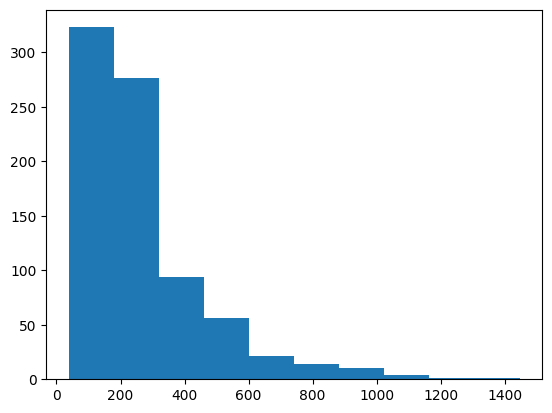

In [ ]:
import matplotlib.pyplot as plt

plt.hist(X_train['encoded'].apply(lambda x : len(x)))

In [ ]:
sentence_length = 600

# post padding
# prev가 좋다는 듯
def padding(sentence, max_len) :
  padded = np.zeros(max_len)

  if len(sentence) != 0 :
    padded[:len(sentence)] = sentence[:max_len]

  return padded


X_train['encoded_padding'] = X_train['encoded'].apply(lambda x : padding(x, sentence_length))
X_test['encoded_padding'] = X_test['encoded'].apply(lambda x : padding(x, sentence_length))


# 모델링

## 모델 정의

In [ ]:
class TextRNNClassifier(nn.Module) :

  # vocab_size :
  # embedding_dim :
  # hidden_dim :
  # output_dim :

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim) :
    super(TextRNNClassifier, self).__init__()

    # Vocab Size X E
    # Embedding[i] : i-th 단어에 대한 임베딩 벡터 (shape: 1 X E)
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # input_size: 단어 벡터 길이 (E)
    # hidden_size: RNN 출력 차원 (H)
    # --> input X W = (N X L x E) X (E x H) --> N X L X H,
    # 최종 output: L X N X H
    self.rnn = nn.RNN(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = 1, batch_first = True)

    self.ff = nn.Linear(hidden_dim, output_dim)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, text) :
    # text: N X L

    embedded = self.embedding(text)
    # N X L X E

    output, hn = self.rnn(embedded) # * batch_first = true
    # output  -> N X L X H
    # hn      -> num_layers X N X H

    # ff: H X O
    # output: N X O
    # return self.softmax(self.ff(hn[-1]))
    return self.ff(hn[-1])


## 데이터, 데이터로더

In [ ]:
from torch.utils.data import Dataset, DataLoader

class IMDBLoader(Dataset) :

  def __init__(self, X, y) :
    self.X = torch.tensor(np.array(X.values.tolist())).to(torch.int64)
    self.y = torch.tensor(np.array(y.values.tolist())).to(torch.int64)

  def __len__(self) :
    return len(self.X)

  def __getitem__(self, idx) :
    return self.X[idx], self.y[idx]

In [ ]:
train_dataset = IMDBLoader(X_train['encoded_padding'], y_train)

train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

## 학습

In [ ]:
def train(model, optimizer, data_loader, epochs = 10, log = None, verbose = False) :
  model = model.to(device)

  for e in range(epochs) :
    model.train()
    for i, (x, y) in enumerate(data_loader) :
      x = x.to(device)

      y = y.to(device)

      pred = model(x)

      loss_func = nn.CrossEntropyLoss()
      loss = loss_func(pred.to(torch.float32), y.squeeze(dim = -1))

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if verbose :
        print(loss.item())
      log.append(loss.item())

  return log

In [ ]:
import torch.optim as optim

classifier = TextRNNClassifier(len(vocab) + 2, 100, 128, 2)

In [ ]:
optimizer = optim.Adagrad(classifier.parameters(), lr = 0.001)
result = train(classifier, optimizer, train_dataloader, 1000, [], True)

0.6172077655792236
0.5862413644790649
1.0304404497146606
0.7215999364852905
0.7793297171592712
0.7713861465454102
0.6943660378456116
0.6599904298782349
0.7105852365493774
0.6741809844970703
0.7088710069656372
0.7010826468467712
0.7194717526435852
0.6699936389923096
0.6977742910385132
0.6617974638938904
0.7171512842178345
0.6715750694274902
0.7403866052627563
0.7064327001571655
0.6888561248779297
0.6744650602340698
0.7650508284568787
0.7018718719482422
0.7496508359909058
0.6921635270118713
0.6946430206298828
0.6723476648330688
0.7022252082824707
0.6851517558097839
0.6997568011283875
0.7493178844451904
0.6827473044395447
0.645229160785675
0.5992541909217834
0.6615762114524841
0.7866865396499634
0.7062327861785889
0.6944999098777771
0.7198647856712341
0.6555842161178589
0.7189194560050964
0.7302260994911194
0.6438217759132385
0.6801358461380005
0.692746639251709
0.7150223255157471


KeyboardInterrupt: ignored

In [ ]:
classifier.eval()
classifier(torch.tensor(X_train['encoded_padding'][0][:2]).to(torch.int32))

tensor([-0.9086,  0.5385], grad_fn=<AddBackward0>)

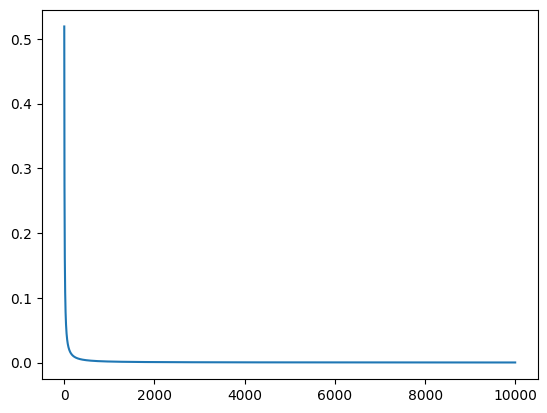

In [ ]:
plt.plot(result[2:])